# 構造

## [Q1] エントロピー弾性

長さ1の棒がN個つながった2次元状の高分子．棒同士のつなぎ目でランダムな方向を向く．144個の高分子を生成して並べてプロット．

6.4節参照．

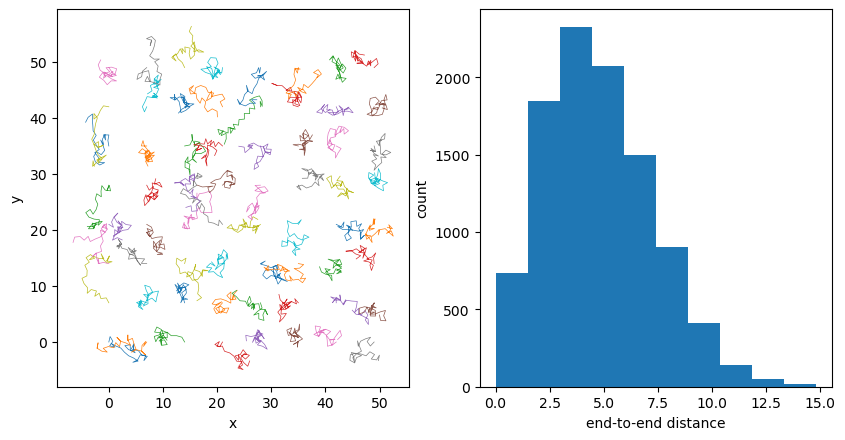

末端間距離の平均 =  4.776474330434544


In [336]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ
    

# ランダムウォーク．p: １ステップあたりの確率．N: ステップの数．
def polymer( N):     
    theta = np.random.rand(N)*2*np.pi
    
    x = np.zeros(N)
    y = np.zeros(N)
    for i in range(N-1):
        x[i+1] = x[i] + np.cos(theta[i])
        y[i+1] = y[i] + np.sin(theta[i])
    
    L = np.sqrt(x[N-1]*x[N-1]+y[N-1]*y[N-1]) # 末端間距離
    
    return x, y, L

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi = 100)

# 同じ計算を10回して重ねてプロット．まとめて，MSDを計算．
N = 30 # 高分子の長さ

d = 7 # プロットする間隔
for i in range(64):
    x, y, dummy = polymer(N) 
    ax1.plot(x + (i%8)*d, y + int(i/8)*d, lw = 0.5)  # lwは線の太さ．

ax1.set_xlabel('x')
ax1.set_ylabel('y')

L = np.zeros(10000)
for i in range(10000):
    x, y, L[i] = polymer(N) 
ax2.hist(L) # 末端館距離 L の分布

ax2.set_xlabel('end-to-end distance')
ax2.set_ylabel('count')

plt.show()

print('末端間距離の平均 = ', np.mean(L))

## [Q2] 枯渇力

- 2つの大きな粒子（半径 rL）と，N-2個の小さな粒子（半径 rS）がブラウン運動．
- 大きな粒子の厚み rDの領域には小さな粒子は接近できない．大きな粒子は接近できる．
- この排除体積のため，大きな粒子同士には引力が働く．すなわち，大きな粒子同士が近づいた方が，小さいな粒子にいは動けるスペースが増えるのでエントロピー的に得．
- 小さい粒子同士には相互作用はない．すれ違える．
- 周期境界で計算．セルの端っこにいると逆側にも粒子が表示される．

平均距離 = 6.30 um


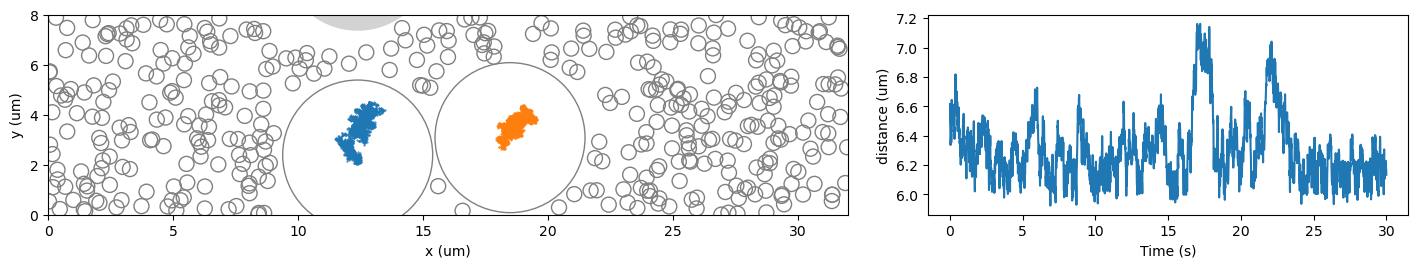

In [651]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ

kBT = 4.14E-21  # (J = kg m^2 / s^2)

N = 400 # 粒子数（大きい粒子を含むので，最低 2）．多すぎると初期配置ができず無限ループに陥るので注意．
Lx, Ly = 32E-6, 8E-6 # 容器サイズ (um)
rL, rS = 3E-6, 0.3E-6 # 大きい粒子と小さい粒子の半径
a =1E-9
f0 = 1E-8
gamma0 = 1E-8 # 半径0.5umの時の摩擦係数 (kg/s) 
   
T = 30 # (s) 計算時間
dt = 1E-2 # (s) 計算の時間刻み


# メインの関数．ランジュバン方程式をオイラー法で数値積分．
def langevin(dt, T, gamma):  # 時間刻み dt で T だけ計算   
    
    r = np.full(N, rS) # 半径
    r[0], r[1] = rL, rL
    
    gamma= gamma0 *r/0.5E-6 # 摩擦係数        
    w = np.sqrt(2*kBT*dt/gamma)  # ルートの中にdtを入れる
            
    # 粒子を配置    
    x = np.zeros(N)
    y = np.zeros(N)    
    
    x[0], x[1] = Lx/2-rL*1.1, Lx/2+rL*1.1 # 大きな粒子の初期位置は固定する．微妙な距離でスタート
    y[0], y[1] = Ly/2, Ly/2
    
    for k in range(2, N): # 大きな粒子と被らないように小さな粒子を配置
        while True:
            x[k] = np.random.rand()*Lx
            y[k] = np.random.rand()*Ly
            
            d0 = np.sqrt((x[k]-x[0])*(x[k]-x[0]) + (y[k]-y[0])*(y[k]-y[0]))
            d1 = np.sqrt((x[k]-x[1])*(x[k]-x[1]) + (y[k]-y[1])*(y[k]-y[1]))          
            
            if (d0 > r[k] + r[0]  + 30E-9) and (d1 > r[k] + r[1]  + 30E-9):
                break
    
    stepN = int(T / dt)  # ステップ数
    sx = np.zeros((stepN, 2)) # 大きな粒子は時系列を記録しておく．
    sy = np.zeros((stepN, 2))
    
    for i in range(stepN):
        
        # 相互作用の計算
        fx = np.zeros(N)
        fy = np.zeros(N)
        for k in range(N):   
            if k<=1:
                xx, yy, rr = x, y, r
            else:
                xx, yy, rr = x[:2], y[:2], r[:2]
            
            dx = (xx - x[k] +Lx/2)%Lx - Lx/2
            dy = (yy - y[k] +Ly/2)%Ly - Ly/2
            
            d = np.sqrt(dx*dx + dy*dy) - (r[k] + rr)          
            d = np.clip(d, 20E-9,1)
            
            ff = -f0*12/a*np.power(d/a, -13)/d
            
            fx[k] = np.sum(ff*dx)  # U(r) = (r/ a)^(-12), dUdr = -12/a*(r/a)^(-13)
            fy[k] = np.sum(ff*dy)
                
        x = (x + dt * fx/gamma + w*np.random.standard_normal(N)) % Lx
        y = (y + dt * fy/gamma + w*np.random.standard_normal(N)) % Ly
                
        sx[i,:] = x[0:2]
        sy[i,:] = y[0:2]
        
    return x, y, r, sx, sy

x, y, r, sx, sy = langevin(dt, T, gamma) # 計算

# 左の図
fig = plt.figure(figsize=(16,2), dpi=100.0)

ax1 = fig.add_axes([0, 0,0.5 , 1], xlabel = 'x (um)', ylabel = 'y (um)')

ax1.set_xlim(0, Lx*1E6)
ax1.set_ylim(0, Ly*1E6)

# 円のプロット．軸と大きさを合わせるため，Circleを用いている．また，はみだした分も表示するため，大きな粒子については ずらした場所にもプロットする．
lx = [Lx, -Lx, 0, 0, Lx, Lx, -Lx, -Lx]
ly = [0, 0, Ly, -Ly, Ly, -Ly, -Ly, Ly]

for i in range(N):
    ax1.add_artist(plt.Circle((x[i]*1E6, y[i]*1E6), r[i]*1E6, color = 'gray', fill = (i < 0)))
    if i<2:
        for llx, lly in zip(lx, ly):
            ax1.add_artist(plt.Circle(((x[i]+llx)*1E6, (y[i]+lly)*1E6), r[i]*1E6, color = 'lightgray', fill = (i < 2)))
        ax1.plot(sx[:, i]*1E6, sy[:, i]*1E6, '.', markersize = 1)
    
# 大きい粒子間の距離の時系列
ax2 = fig.add_axes([0.55, 0, 0.3, 1], xlabel = 'Time (s)', ylabel = 'distance (um)')

dx = (sx[:,0]-sx[:,1]+Lx/2)%Lx-Lx/2
dy = (sy[:,0]-sy[:,1]+Ly/2)%Ly-Ly/2
d = np.sqrt(dx*dx+dy*dy)
t = np.linspace(0, T, len(d))   

print("平均距離 = {:.2f} um".format(np.mean(d*1E6)))

ax2.plot(t, d*1E6)
plt.show()